In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, LogLocator, LogFormatter, LogFormatterMathtext, NullFormatter

plt.rcParams['font.family'] = 'Nimbus Roman'
mpl.rcParams["text.usetex"] = True

# Data extraction

In [10]:
energy_per_omega_per_basis = {}
rij_init_time_per_omega_per_basis = {}
rij_per_iter_per_omega_per_basis = {}
xc_per_iter_per_omega_per_basis = {}

for basis in ["ccpvdz"]:
    df = pd.read_csv(f"data_{basis}.csv")

    cc_2e3c = df["2e3c-CC(s)"].astype(float).to_numpy()
    cd_2e3c = df["2e3c-CD(s)"].astype(float).to_numpy()
    sr_2e2c = df["2e2c(s)"].astype(float).to_numpy()
    rij_total_time = df["RIJ-BIGMEM(s)"].astype(float).to_numpy()
    xc_time = df["DFT-XC(s)"].astype(float).to_numpy()
    energy = df["Energy"].astype(float).to_numpy()
    niter = df["niter"].astype(float).to_numpy()
    
    supercell = df["Supercell"].astype(str).to_numpy()
    omega = df["Omega"].astype(str).to_numpy()

    rij_init_time = sr_2e2c + cc_2e3c + cd_2e3c 
    # Time per iteration for J build
    rij_per_iter = (rij_total_time - cc_2e3c - cd_2e3c - sr_2e2c) / niter
    # Time per iteration for XC
    xc_per_iter = xc_time / niter

    # Extract the data that belongs to similar range-separated omega value
    energy_per_omega = {}
    rij_init_time_per_omega = {}
    rij_per_iter_per_omega = {}
    xc_per_iter_per_omega = {}
    for w in range(len(omega)):
        key = omega[w]
        if key not in rij_init_time_per_omega:
            energy_per_omega[key] = []
            rij_init_time_per_omega[key] = []
            rij_per_iter_per_omega[key] = []
            xc_per_iter_per_omega[key] = []
        
        energy_per_omega[key].append(energy[w])
        rij_init_time_per_omega[key].append(rij_init_time[w])
        rij_per_iter_per_omega[key].append(rij_per_iter[w])
        xc_per_iter_per_omega[key].append(xc_per_iter[w])
        

    energy_per_omega_per_basis[basis] = energy_per_omega
    rij_init_time_per_omega_per_basis[basis] = rij_init_time_per_omega
    rij_per_iter_per_omega_per_basis[basis] = rij_per_iter_per_omega
    xc_per_iter_per_omega_per_basis[basis] = xc_per_iter_per_omega


# Extract the memeory requirement for storing the integral here
memory_per_omega_per_basis = {}
for basis in ["ccpvdz"]:
    df = pd.read_csv(f"memory_{basis}.csv")
    
    static_mem = df["StaticMem(GB)"].astype(float).to_numpy()
    # Convert GiB to GB
    static_mem *= 1024 * 1024 * 1024
    static_mem /= 10**9
    
    memory_per_omega = {}

    omega = df["Omega"].astype(str).to_numpy() # Contain redundant omega
    
    for w in range(len(omega)):
        key = omega[w]
        if key not in memory_per_omega:
            memory_per_omega[key] = []
        
        memory_per_omega[key].append(static_mem[w])
    
    memory_per_omega_per_basis[basis] = memory_per_omega

# Plot wall time and storage

Init time vs supercell size
w = 0.3 has n = 1.5262789840948046
w = 0.6 has n = 1.5663653112380502
w = 0.9 has n = 1.7495471135505027


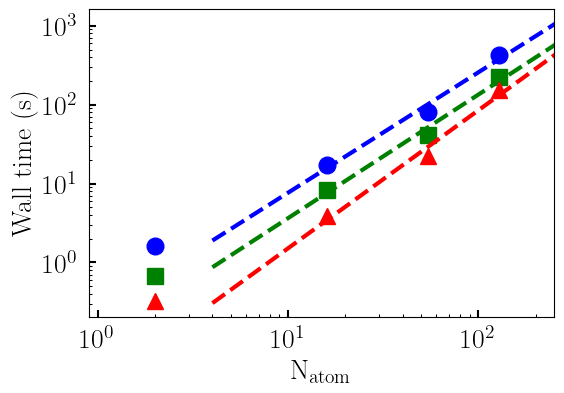

Time per iteration vs supercell size
w = 0.3 has n = 1.9401696959027432
w = 0.6 has n = 1.7157620123673507
w = 0.9 has n = 1.597910578597264


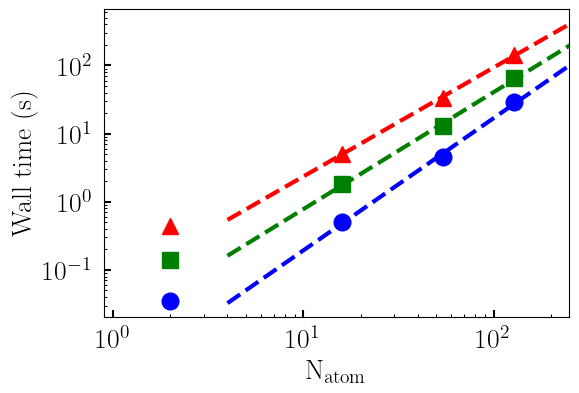

Storage requirement vs supercell size
w = 0.3 has n = 2.8310852238505007
w = 0.6 has n = 2.8201229518439788
w = 0.9 has n = 2.671573725273084


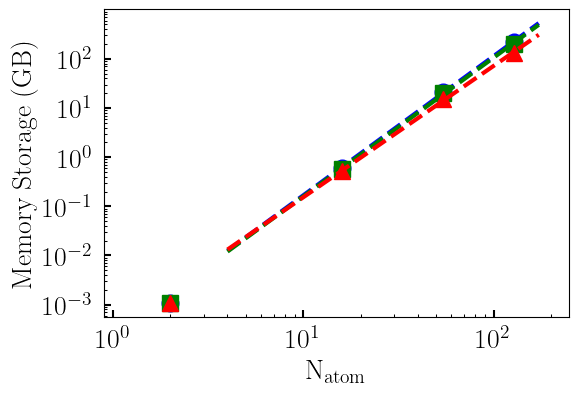

In [11]:
# Plot the data
omega_vals = ['0.3', '0.6', '0.9']
omega_labels = ['o', 's', '^']
supercell = [2 * i * i * i for i in range(1,5)] # we did 1x1x1, 2x2x2, 3x3x3, 4x4x4 starting from 2 atoms in the unit cell
basis_series = ["ccpvdz"]
color_series = ["blue", "green", "red"]

fs = 20
ms = 12

print("Init time vs supercell size")
coeffs_init_time_per_omega_per_basis = {}
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    coeffs_per_omega = {}
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        time = rij_init_time_per_omega_per_basis[basis][w]
                    
        log_supercell = np.log(supercell[1:])
        log_rij_per_iter = np.log(time[1:])
        coeffs = np.polyfit(log_supercell, log_rij_per_iter, 1)
        n = coeffs[0]      # scaling exponent
        print("w = " + str(w) + " has n = " + str(n))
        coeffs_per_omega[w] = coeffs

    coeffs_init_time_per_omega_per_basis[basis] = coeffs_per_omega  

# RIJ init time vs supercell
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        colors = color_series[idx]
        marker_type = omega_labels[idx]
        ax.plot(supercell, rij_init_time_per_omega_per_basis[basis][w], marker = marker_type, color = colors, markersize=ms, linestyle="None", label = rf"$\omega = {w}$")
        
        # Plot the fitting line here
        coeffs = coeffs_init_time_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 4 * 4**3, 40)
        time_per_iter_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax.plot(natom_fit, time_per_iter_fit, color = colors, linestyle="--", linewidth= 3)
        
    ax.set_xlabel(r"N$_\mathrm{atom}$", size = fs)
    ax.set_ylabel(r"Wall time (s)", size = fs)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fs, pad = 8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xlim([0.9, 250])
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax.tick_params(axis='y', which='major', length=5, width=1.5)
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.75)
    
    ax.set_xticks([1, 10, 100])
    ax.tick_params(axis='x', which='major', length=5, width=1.5)
    ax.tick_params(axis='x', which='minor', length=2.5, width=0.75)

plt.show()

# Fitting time per iteration with the supercell size
print("Time per iteration vs supercell size")
coeffs_time_per_iter_per_omega_per_basis = {}
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    coeffs_per_omega = {}
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        time = rij_per_iter_per_omega_per_basis[basis][w]
                    
        log_supercell = np.log(supercell[1:])
        log_rij_per_iter = np.log(time[1:])
        coeffs = np.polyfit(log_supercell, log_rij_per_iter, 1)
        n = coeffs[0]      # scaling exponent
        print("w = " + str(w) + " has n = " + str(n))
        coeffs_per_omega[w] = coeffs
        
    coeffs_time_per_iter_per_omega_per_basis[basis] = coeffs_per_omega  

# RIJ per iteration
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        
        colors = color_series[idx]
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        ax.plot(supercell, rij_per_iter_per_omega_per_basis[basis][w], marker = marker_type, markersize=ms, color = colors, linestyle="None", label = rf"$\omega = {w}$")

        # Plot the fitting line here
        coeffs = coeffs_time_per_iter_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 4 * 4**3, 40)
        time_per_iter_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax.plot(natom_fit, time_per_iter_fit, color = colors, linestyle="--", linewidth= 3)
        
    ax.set_xlabel(r"N$_\mathrm{atom}$", size = fs)
    ax.set_ylabel(r"Wall time (s)", size = fs)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fs, pad = 8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xlim([0.9, 250])
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax.tick_params(axis='y', which='major', length=5, width=1.5)
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.75)
    
    ax.set_xticks([1, 10, 100])
    ax.tick_params(axis='x', which='major', length=5, width=1.5)
    ax.tick_params(axis='x', which='minor', length=2.5, width=0.75)

plt.show()

# Fitting the storage data
print("Storage requirement vs supercell size")
coeffs_storage_per_omega_per_basis = {}
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    coeffs_storage_per_omega = {}
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        storage = memory_per_omega_per_basis[basis][w]
                    
        log_supercell = np.log(supercell[1:])
        log_storage = np.log(storage[1:])
        coeffs = np.polyfit(log_supercell, log_storage, 1)
        n = coeffs[0]      # scaling exponent
        print("w = " + str(w) + " has n = " + str(n))
        
        coeffs_storage_per_omega[w] = coeffs
    coeffs_storage_per_omega_per_basis[basis] = coeffs_storage_per_omega

# Converged storage at different omega
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        colors = color_series[idx]
        ax.plot(supercell, memory_per_omega_per_basis[basis][w], color = colors, marker = marker_type, markersize = ms, linestyle="None", label = rf"$\omega = {w}$")

        # Plot the fitting line here
        coeffs = coeffs_storage_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 2.7 * 4**3, 40)
        storage_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax.plot(natom_fit, storage_fit, color = colors, linestyle="--", linewidth= 3)
        
    ax.set_xlabel(r"N$_\mathrm{atom}$", size = fs)
    ax.set_ylabel(r"Memory Storage (GB)", size = fs)
    ax.tick_params(axis='both', which='both', direction='in', labelsize = fs, pad = 8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim([0.9, 250])
    
    ax.set_xticks([1, 10, 100])
    ax.tick_params(axis='x', which='major', length=5, width=1.5)
    ax.tick_params(axis='x', which='minor', length=2.5, width=0.75)
        
    ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10)*0.1, numticks=100))
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax.tick_params(axis='y', which='major', length=5, width=1.5)
    ax.tick_params(axis='y', which='minor', length=2.5, width=0.75)

marker_handles = handles=[
    Line2D([0], [0], marker=omega_labels[0], color=color_series[0], markersize = ms, linestyle='None', label=r'$\omega$ = 0.3'),
    Line2D([0], [0], marker=omega_labels[1], color=color_series[1], markersize = ms, linestyle='None', label=r'$\omega$ = 0.6'),
    Line2D([0], [0], marker=omega_labels[2], color=color_series[2], markersize = ms, linestyle='None', label=r'$\omega$ = 0.9')]

plt.show()

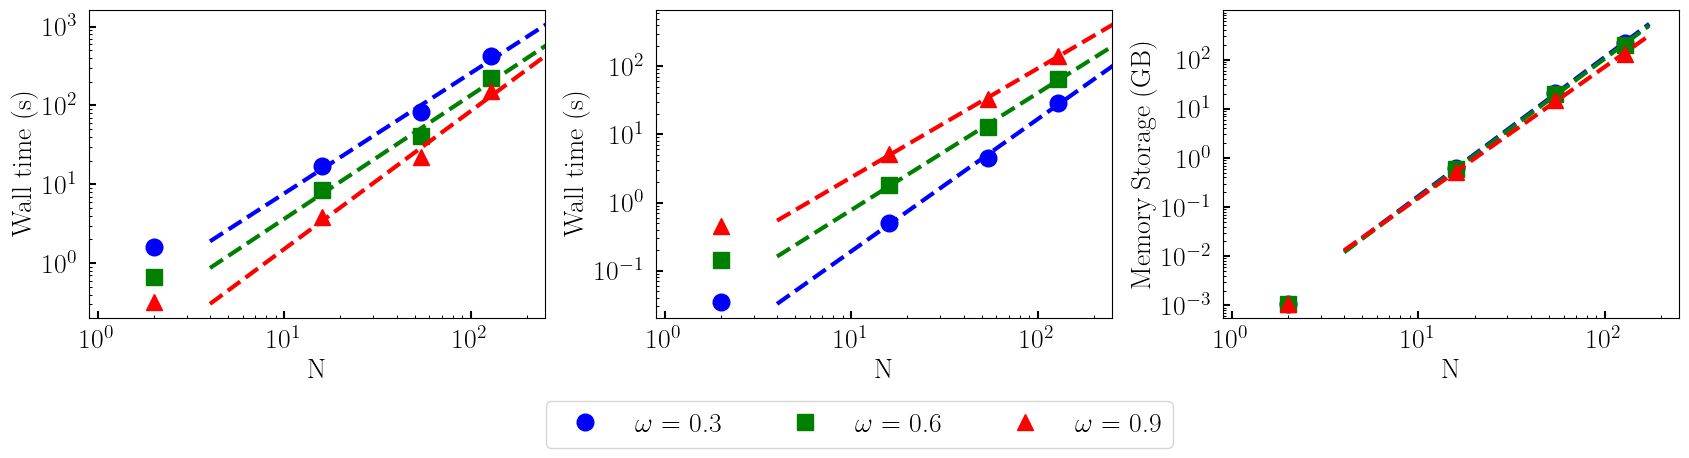

In [13]:
# Plot the data
omega_vals = ['0.3', '0.6', '0.9']
omega_labels = ['o', 's', '^']
supercell = [2 * i * i * i for i in range(1,5)] # we did 1x1x1, 2x2x2, 3x3x3, 4x4x4 starting from 2 atoms in the unit cell
basis_series = ["ccpvdz"]
color_series = ["blue", "green", "red"]

fs = 20
ms = 12

# RIJ init time vs supercell
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        colors = color_series[idx]
        marker_type = omega_labels[idx]
        ax[0].plot(supercell, rij_init_time_per_omega_per_basis[basis][w], marker = marker_type, color = colors, markersize=ms, linestyle="None", label = rf"$\omega = {w}$")
        
        # Plot the fitting line here
        coeffs = coeffs_init_time_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 4 * 4**3, 40)
        init_time_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax[0].plot(natom_fit, init_time_fit, color = colors, linestyle="--", linewidth= 3)

    ax[0].set_xlabel(r"N", size = fs)
    ax[0].set_ylabel(r"Wall time (s)", size = fs)
    ax[0].tick_params(axis='both', which='both', direction='in', labelsize=fs, pad = 8)
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    ax[0].set_xlim([0.9, 250])

    ax[0].tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax[0].tick_params(axis='y', which='major', length=5, width=1.5)
    ax[0].tick_params(axis='y', which='minor', length=2.5, width=0.75)

    ax[0].set_xticks([1, 10, 100])
    ax[0].tick_params(axis='x', which='major', length=5, width=1.5)
    ax[0].tick_params(axis='x', which='minor', length=2.5, width=0.75)

# RIJ per iteration
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        
        colors = color_series[idx]
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        ax[1].plot(supercell, rij_per_iter_per_omega_per_basis[basis][w], marker = marker_type, markersize=ms, color = colors, linestyle="None", label = rf"$\omega = {w}$")

        # Plot the fitting line here
        coeffs = coeffs_time_per_iter_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 4 * 4**3, 40)
        time_per_iter_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax[1].plot(natom_fit, time_per_iter_fit, color = colors, linestyle="--", linewidth= 3)
        
    ax[1].set_xlabel(r"N", size = fs)
    ax[1].set_ylabel(r"Wall time (s)", size = fs)
    ax[1].tick_params(axis='both', which='both', direction='in', labelsize=fs, pad = 8)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    ax[1].set_xlim([0.9, 250])
    
    ax[1].tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax[1].tick_params(axis='y', which='major', length=5, width=1.5)
    ax[1].tick_params(axis='y', which='minor', length=2.5, width=0.75)
    
    ax[1].set_xticks([1, 10, 100])
    ax[1].tick_params(axis='x', which='major', length=5, width=1.5)
    ax[1].tick_params(axis='x', which='minor', length=2.5, width=0.75)

# Converged storage at different omega
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        colors = color_series[idx]
        ax[2].plot(supercell, memory_per_omega_per_basis[basis][w], color = colors, marker = marker_type, markersize = ms, linestyle="None", label = rf"$\omega = {w}$")

        # Plot the fitting line here
        coeffs = coeffs_storage_per_omega_per_basis[basis][w]
        natom_fit = np.linspace(0.5 * 2**3, 2.7 * 4**3, 40)
        storage_fit = np.exp(coeffs[1]) * natom_fit**coeffs[0]
        
        ax[2].plot(natom_fit, storage_fit, color = colors, linestyle="--", linewidth= 3)
        
    ax[2].set_xlabel(r"N", size = fs)
    ax[2].set_ylabel(r"Memory Storage (GB)", size = fs)
    ax[2].tick_params(axis='both', which='both', direction='in', labelsize = fs, pad = 8)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    
    ax[2].set_xlim([0.9, 250])
    
    ax[2].set_xticks([1, 10, 100])
    ax[2].tick_params(axis='x', which='major', length=5, width=1.5)
    ax[2].tick_params(axis='x', which='minor', length=2.5, width=0.75)
        
    ax[2].set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
    ax[2].yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10)*0.1, numticks=100))
    
    ax[2].tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax[2].tick_params(axis='y', which='major', length=5, width=1.5)
    ax[2].tick_params(axis='y', which='minor', length=2.5, width=0.75)

marker_handles = handles=[
    Line2D([0], [0], marker=omega_labels[0], color=color_series[0], markersize = ms, linestyle='None', label=r'$\omega$ = 0.3'),
    Line2D([0], [0], marker=omega_labels[1], color=color_series[1], markersize = ms, linestyle='None', label=r'$\omega$ = 0.6'),
    Line2D([0], [0], marker=omega_labels[2], color=color_series[2], markersize = ms, linestyle='None', label=r'$\omega$ = 0.9')]

fig.legend(handles=marker_handles,
           loc='lower center',
           bbox_to_anchor=(0.51, -0.25),   # adjust vertical offset
           fontsize=fs,
           ncol=3)

pos_1 = ax[1].get_position()
ax[1].set_position([pos_1.x0 + 0.01, pos_1.y0, pos_1.width, pos_1.height])
pos_2 = ax[2].get_position()
ax[2].set_position([pos_2.x0 + 0.02, pos_2.y0, pos_2.width, pos_2.height])

plt.show()